In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv('../analytic_stuff/python_Beklaryan/Machine_Learning_datasets/clustering.csv')

In [5]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [6]:
data.shape

(381, 13)

In [7]:
# Приводим к числовому виду
X = data
X['Gender'] = X['Gender'].map({"Male":0, "Female":1})
X['Married'] = X['Married'].map({"No":0, "Yes":1})
X['Education'] = X['Education'].map({"Not Graduate":0, "Graduate":1})
X['Self_Employed'] = X['Self_Employed'].map({"No":0, "Yes":1})
X['Loan_Status'] = X['Loan_Status'].map({"N":0, "Y":1})
X['Dependents'] = X['Dependents'].map({'0':0, '1':1, '2':2, '3':3, '3+':4})
X['Property_Area'] = X['Property_Area'].map({"Rural":1, "Urban":2, "Semiurban":2})
X = X.iloc[:,-12:]
X = X.replace(np.nan, -1, regex=True)
#X.dropna(inplace=True)
X.shape

(381, 12)

In [8]:
from sklearn.preprocessing import MinMaxScaler 
# Нормализуем данные
mms = MinMaxScaler()
mms.fit(X)
X_transformed = mms.transform(X)

In [9]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

#рисуем штучку, которая сокращает размерность

def plot_LSA(data, test_labels=[], colors=['orange','blue'], savepath="PCA_demo.csv", plot=True, ):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(data)
        lsa_scores = lsa.transform(data)
        if len(test_labels) > 0:
            color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
            color_column = [color_mapper[label] for label in test_labels]
            if plot:
                plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=mcolors.ListedColormap(colors))
        elif plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8)

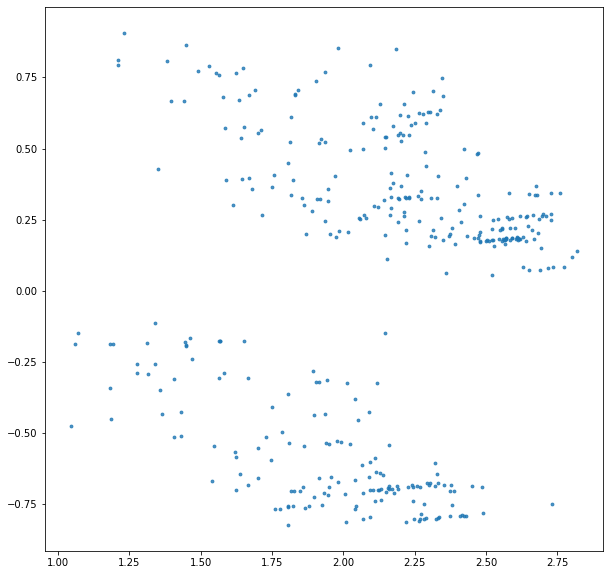

In [10]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_transformed)
plt.show()

Тут ярко выражены 2 кластера. Поэтому везде буду делить на 2 кластера (в KMeans проверю на диаграмке одной)

In [11]:
#training k-means model
from sklearn.cluster import KMeans

sum_of_squared_distances_tr = []
K = range(1,6)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_transformed)
    sum_of_squared_distances_tr.append(km.inertia_)

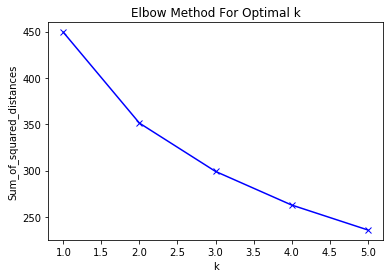

In [12]:
plt.plot(K, sum_of_squared_distances_tr, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

На картинке выше выход на плато идет на цифре 2, поэтому остановимся на 2х кластерах.

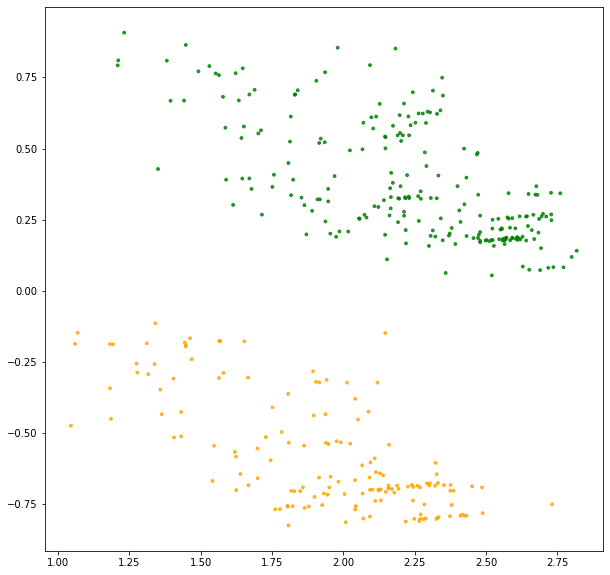

In [13]:
km_tr = KMeans(n_clusters=2)
km_tr = km_tr.fit(X_transformed)

#predictions from kmeans
pred_tr = km_tr.predict(X_transformed)
fig = plt.figure(figsize=(10, 10))        
plot_LSA(X_transformed, pred_tr, ['orange','blue', 'green'])

На мой взгляд идеально

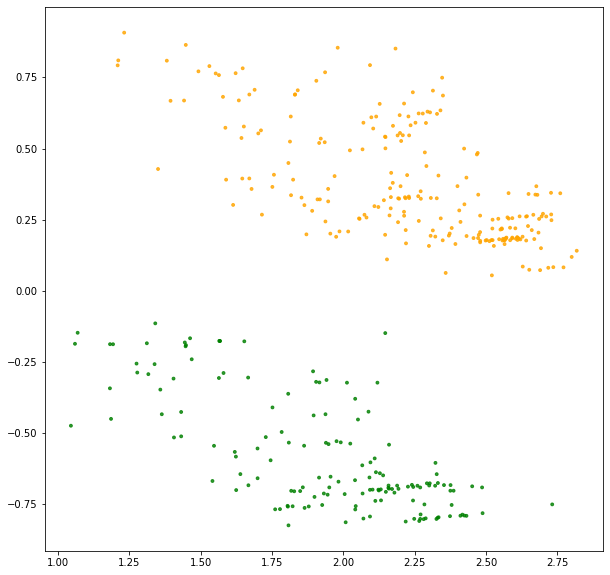

In [14]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, random_state=2)
gmm.fit(X_transformed)

#predictions from gmm
gmm_labels = gmm.predict(X_transformed)
fig = plt.figure(figsize=(10, 10))        
plot_LSA(X_transformed, gmm_labels, ['orange','blue', 'green'])

Так же хорошо как и наверху, но не всегда. Если random_state сменить, то картинка будет другой

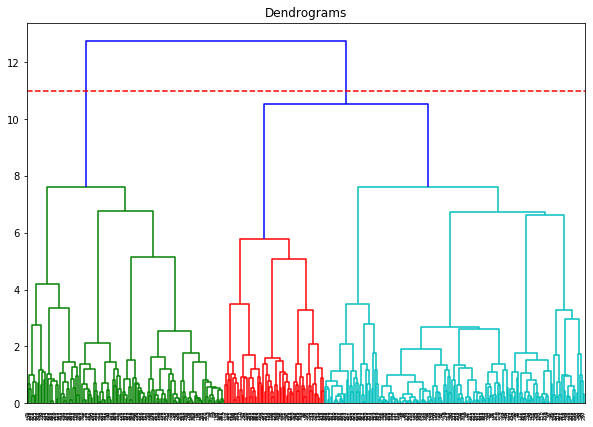

In [15]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_transformed, method='ward', metric='euclidean'))
plt.axhline(y=11, color='r', linestyle='--')

Вообще, здесь красивое разделение на 3 основных кластера. Линия, которую я провела для двух. Внизу сделаю разделение на 2 и 3 кластера.

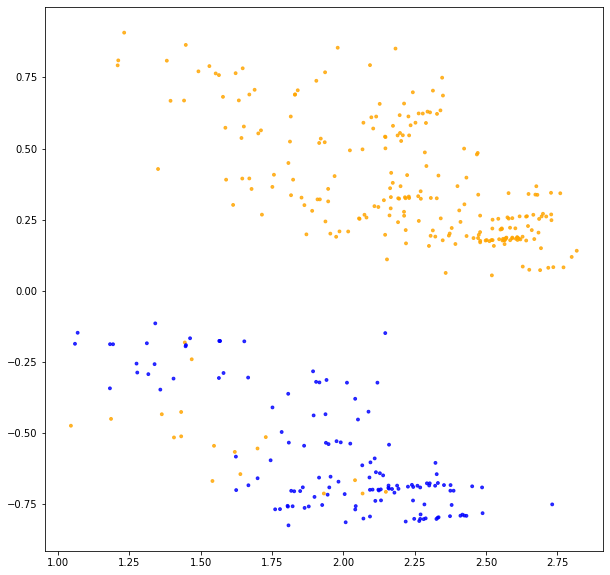

In [16]:
# Здесь на 2 делим
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(X_transformed)

#predictions from gmm
fig = plt.figure(figsize=(10, 10))        
plot_LSA(X_transformed, cluster.labels_, ['orange','blue'])

Этот метод тоже работает, но желтые заблудились слегка среди синих, так что KMeans - ❤️

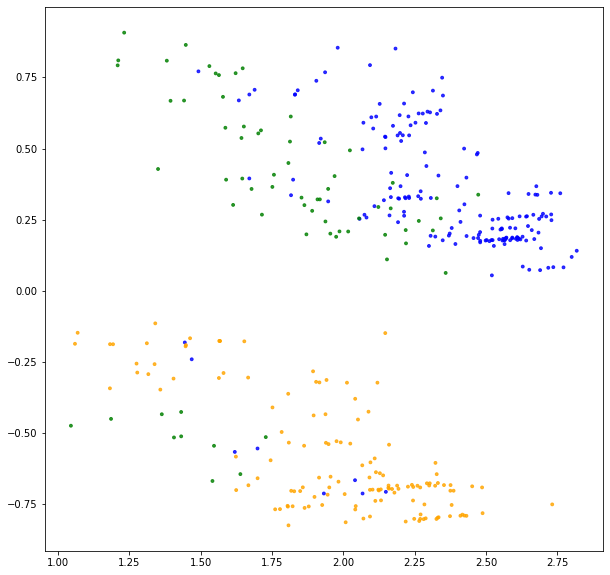

In [17]:
# Здесь на 3
cluster_3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster_3.fit_predict(X_transformed)

#predictions from gmm
fig = plt.figure(figsize=(10, 10))        
plot_LSA(X_transformed, cluster_3.labels_, ['orange','blue', 'green'])

Мне не очень нравится.

In [18]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [19]:
#estimation of epsilon
neigh = NearestNeighbors(n_neighbors=8)
nbrs = neigh.fit(X_transformed)
distances, indices = nbrs.kneighbors(X_transformed)

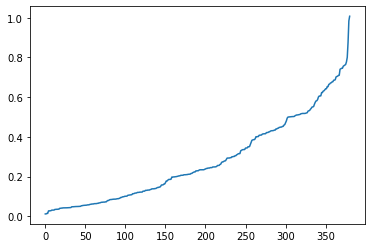

In [20]:
#the optimal value for epsilon will be found at the point of maximum curvature (in this case, 0.3)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [21]:
#train model, selecting 0.3 for eps and setting min_samples to 5
m = DBSCAN(eps=0.8, min_samples=30)
m.fit(X_transformed)
set(m.labels_)

{-1, 0, 1}

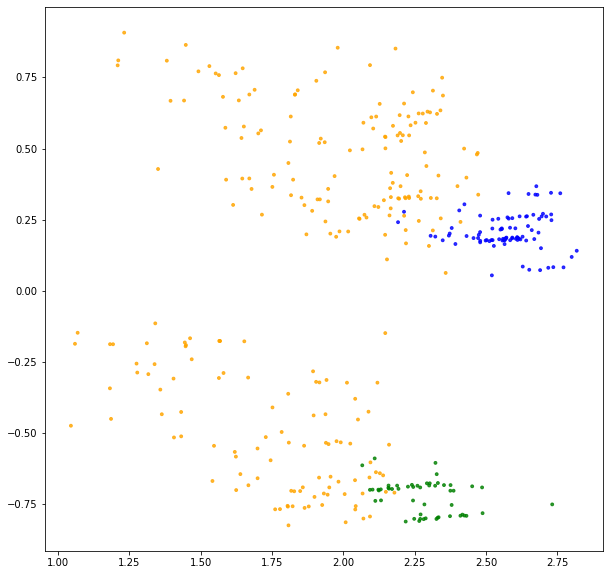

In [22]:
#predictions from gmm
fig = plt.figure(figsize=(10, 10))        
plot_LSA(X_transformed, m.labels_, ['orange','blue', 'green'])

Вообще интересно, что найдены плотностные центры в общем-то правильно,учитывая то, что ближе к оси y данные все более разреженные. Все желтое вокруг - это явно шум этих кластеров.